# Import "Ground Truth" Network

In [2]:
library("gRain")
library("Rgraphviz")
library("bnlearn")

In [3]:
#setwd("/Users/lisa/Documents/Uni/03.SemesterMaster/BN/bn17")
setwd("/Users/kai/Drive/Uni/Nijmegen/WS17_18/BN/")
d <- read.table(header=T, sep=",", 'adult_cleaned.csv')
d[d=="?"]<-NA
d <- d[complete.cases(d),]
d <- data.frame(d)
d <- subset(d, select = -c(native.country) )

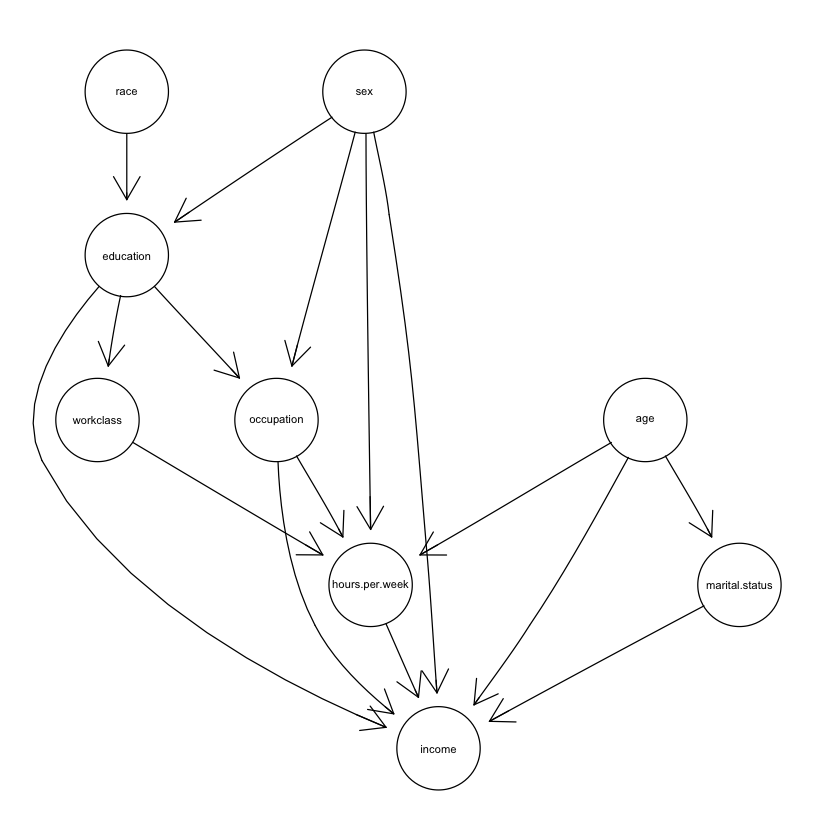

In [4]:
our_network <- dag(~ race + education:race:sex + workclass:education + hours.per.week:workclass:occupation:age:sex + occupation:education:sex + marital.status:age + income:age:sex:occupation:hours.per.week:education:marital.status)
plot(our_network)

# Structure learning using bnlearn
## Convert network to bnlearn

In [5]:
bn_our_network = as.bn(our_network)

In [178]:
# specify variable types
d$age <- as.ordered(d$age)
d$workclass <- as.factor(d$workclass)
d$education <- as.factor(d$education)
d$marital.status <- as.factor(d$marital.status)
d$occupation <- as.factor(d$occupation)
d$race <- as.factor(d$race)
d$sex <- as.factor(d$sex)
d$hours.per.week <- as.ordered(d$hours.per.week)
d$income <- as.ordered(d$income)

## Apply tabu search

Warning message in check.score(score, x):
“no score is available for ordinal data, disregarding the ordering of the levels.”


  Bayesian network learned via Score-based methods

  model:
   [marital.status][race|marital.status][income|marital.status]
   [age|marital.status:income][education|age:income][hours.per.week|age:income]
   [sex|marital.status:hours.per.week][occupation|education:sex:income]
   [workclass|occupation:sex]
  nodes:                                 9 
  arcs:                                  15 
    undirected arcs:                     0 
    directed arcs:                       15 
  average markov blanket size:           4.00 
  average neighbourhood size:            3.33 
  average branching factor:              1.67 

  learning algorithm:                    Tabu Search 
  score:                                 BIC (disc.) 
  penalization coefficient:              5.157169 
  tests used in the learning procedure:  340 
  optimized:                             TRUE 


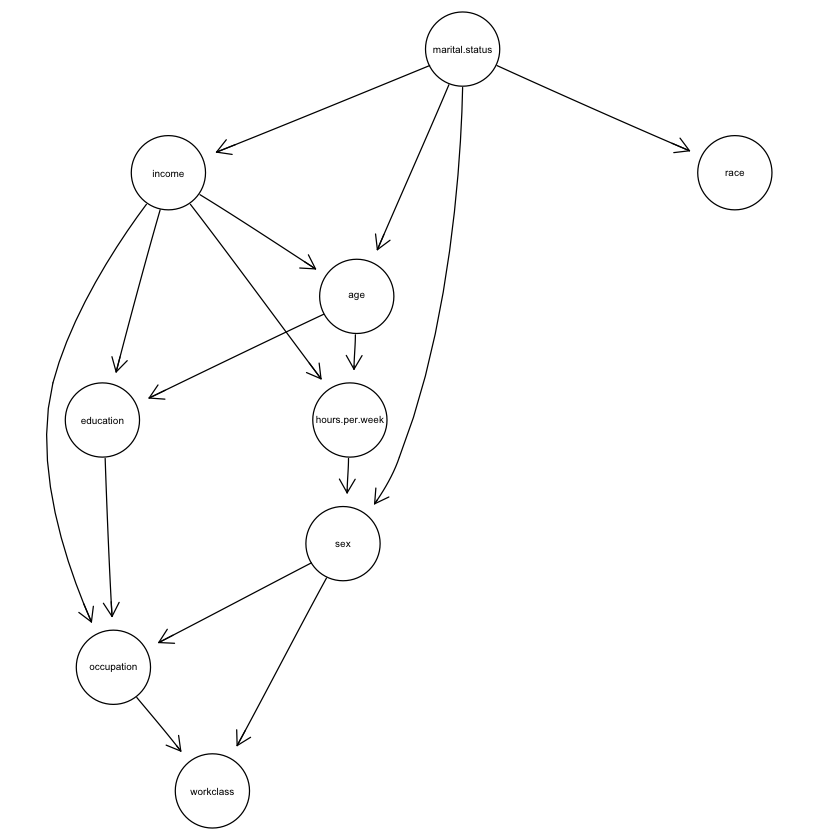

In [116]:
pdag_tabu = tabu(d)
graphviz.plot(pdag_tabu)
pdag_tabu

## Apply Fast Incremental Association

Warning message in FUN(newX[, i], ...):
“vstructure workclass -> occupation <- sex is not applicable, because one or both arcs are oriented in the opposite direction.”Warning message in FUN(newX[, i], ...):
“vstructure workclass -> occupation <- education is not applicable, because one or both arcs are oriented in the opposite direction.”Warning message in FUN(newX[, i], ...):
“vstructure workclass -> hours.per.week <- marital.status is not applicable, because one or both arcs are oriented in the opposite direction.”Warning message in FUN(newX[, i], ...):
“vstructure education -> occupation <- sex is not applicable, because one or both arcs are oriented in the opposite direction.”Warning message in FUN(newX[, i], ...):
“vstructure education -> income <- sex is not applicable, because one or both arcs are oriented in the opposite direction.”Warning message in FUN(newX[, i], ...):
“vstructure education -> income <- marital.status is not applicable, because one or both arcs are oriented i


  Bayesian network learned via Constraint-based methods

  model:
    [partially directed graph]
  nodes:                                 9 
  arcs:                                  11 
    undirected arcs:                     1 
    directed arcs:                       10 
  average markov blanket size:           3.78 
  average neighbourhood size:            2.44 
  average branching factor:              1.11 

  learning algorithm:                    Fast-IAMB 
  conditional independence test:         Mutual Information (disc.) 
  alpha threshold:                       0.05 
  tests used in the learning procedure:  141 
  optimized:                             FALSE 


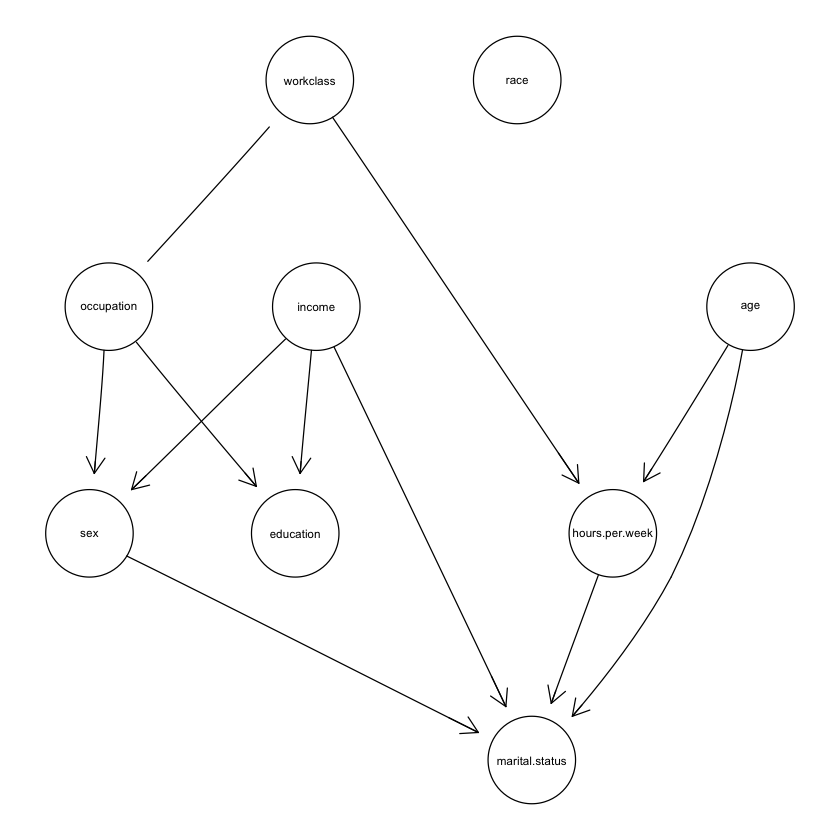

In [117]:
pdag_iamb = fast.iamb(d)
graphviz.plot(pdag_iamb)
pdag_iamb

# Compare networks
## Compare learned networks to ground truth

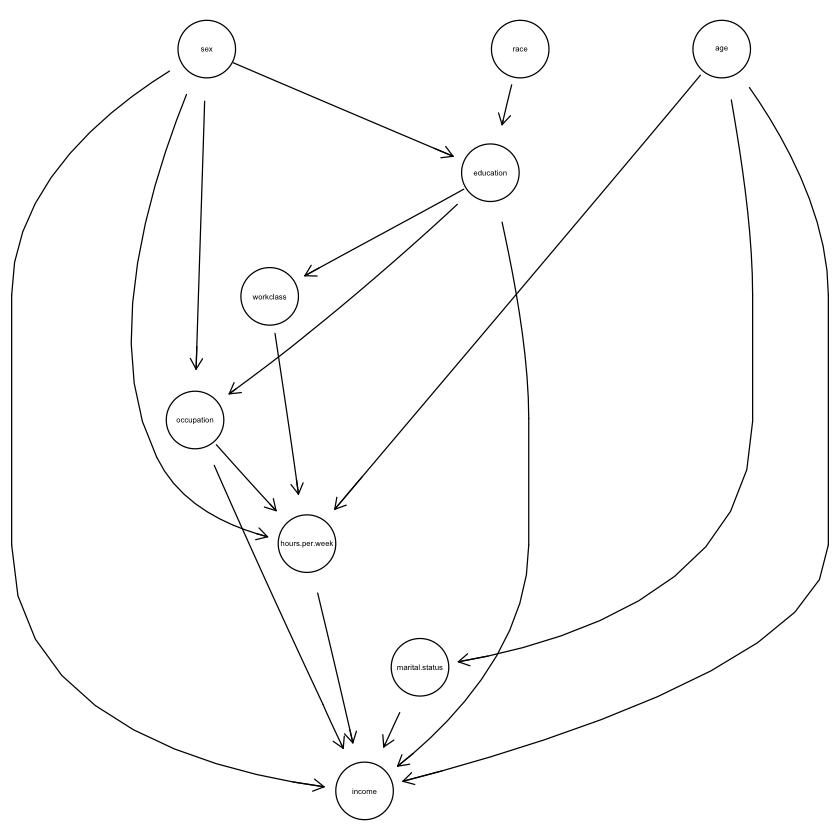

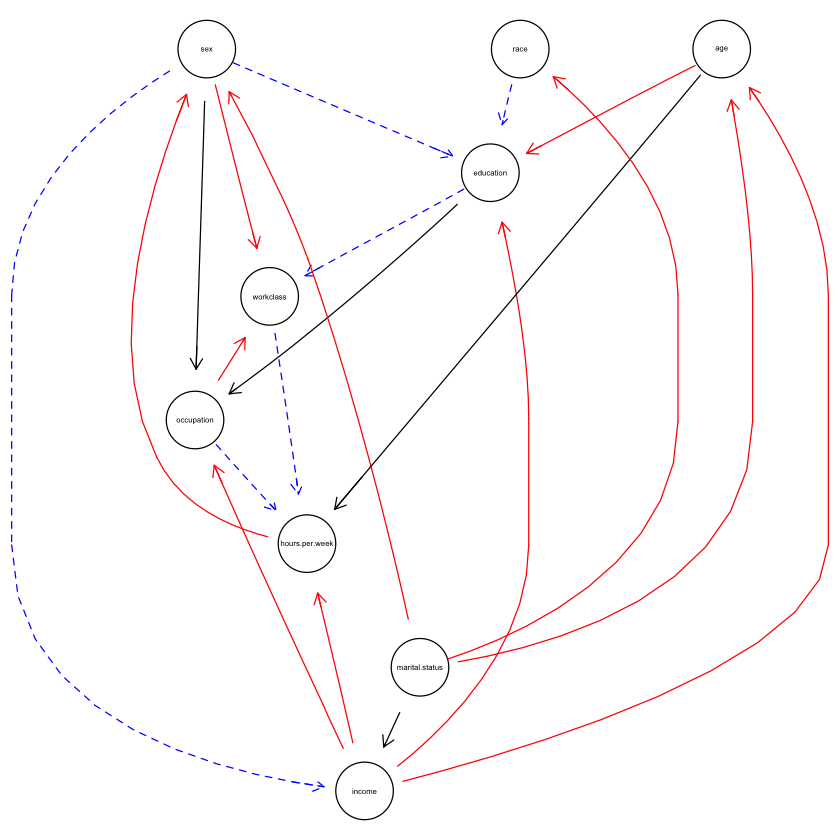

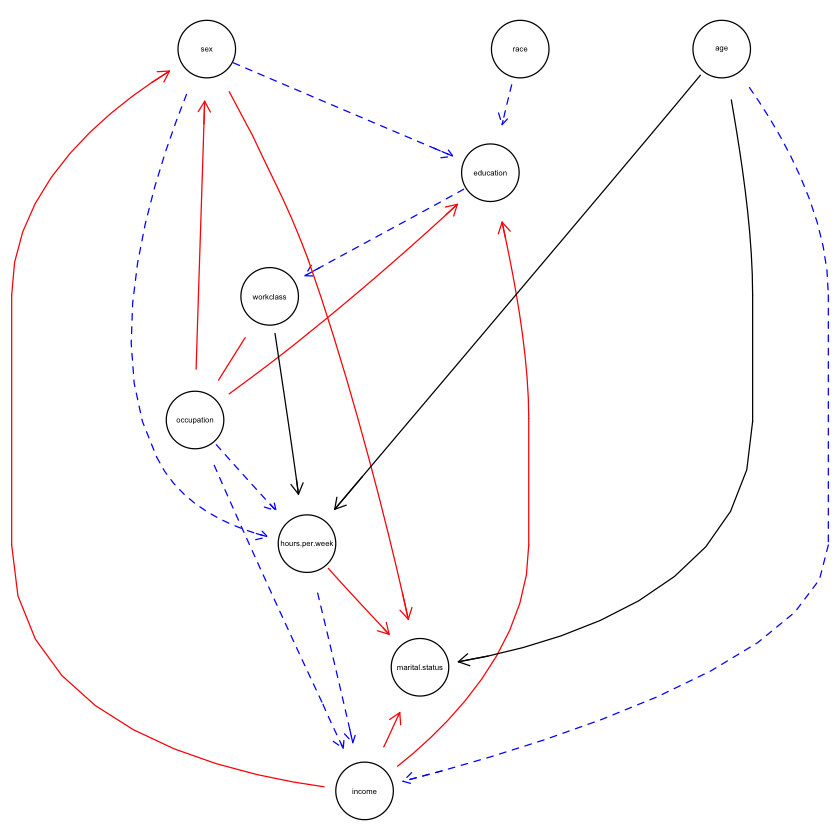

In [181]:
# First network is origina, second tabu, third iamb
graphviz.compare(bn_our_network,pdag_tabu, pdag_iamb)

Red arrows denote arcs that have to be flipped, in order to get back to the original network, blue arrows indicate missing edges and black arcs coincide.

## Compare learned networks with each other

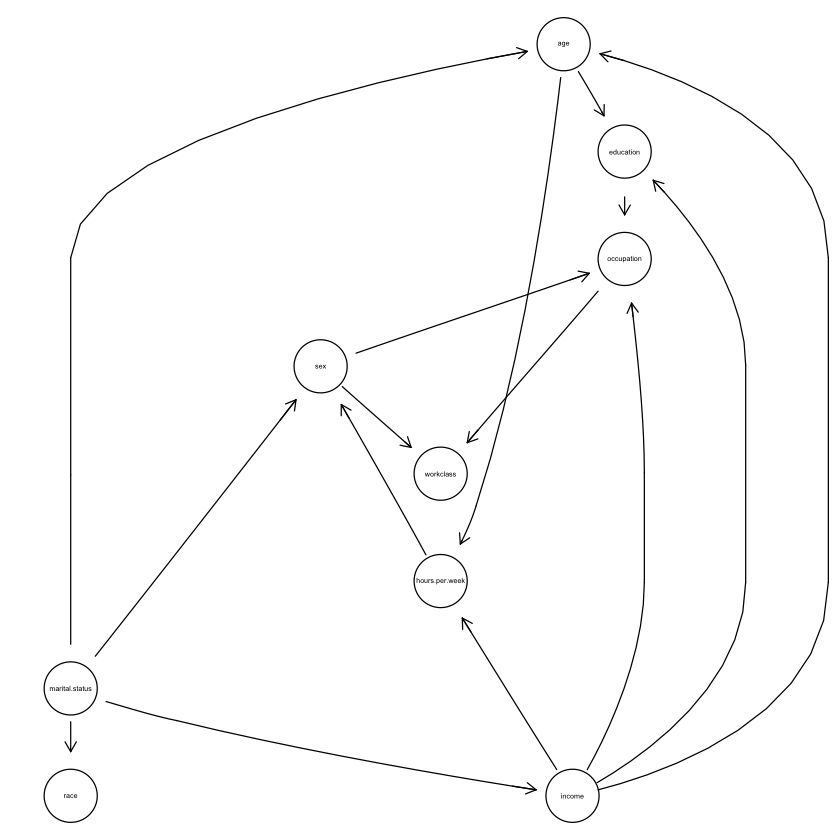

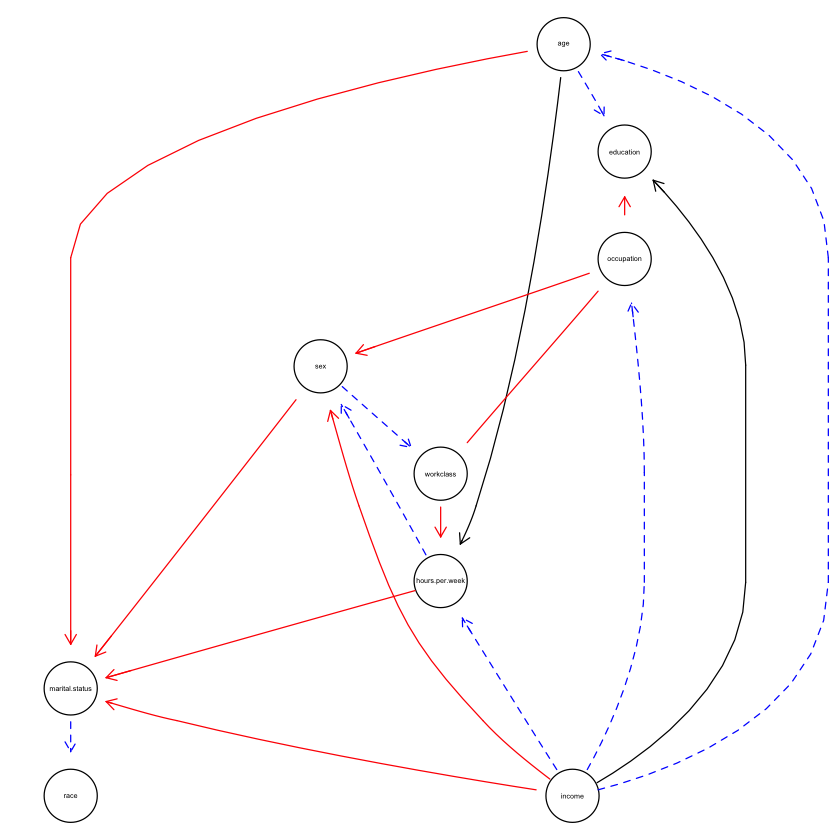

In [126]:
graphviz.compare(pdag_tabu, pdag_iamb)

## Network differences

In [182]:
# Calculate structural Hamming distances
print(shd(bn_our_network, pdag_iamb))
print(shd(bn_our_network, pdag_tabu))
print(shd(pdag_iamb, pdag_tabu))

# Check whether root nodes coincide
setdiff(root.nodes(pdag_iamb),root.nodes(bn_our_network))
setdiff(root.nodes(pdag_tabu),root.nodes(bn_our_network))
setdiff(root.nodes(bn_our_network),root.nodes(pdag_iamb))
setdiff(root.nodes(pdag_iamb),root.nodes(bn_our_network))
setdiff(root.nodes(bn_our_network),root.nodes(pdag_tabu))
setdiff(root.nodes(pdag_tabu),root.nodes(bn_our_network))

[1] 17
[1] 18
[1] 18


[1] 1

[1] 1

[1] "sex"

[1] "income"

[1] "race" "sex"  "age"

[1] "marital.status"

## Define Metric

In [164]:
# The difference between two networks is defined as the structural hamming distance + the number of different root nodes
metric <- function(net1, net2){
    return(shd(net1,net2) + length(setdiff(root.nodes(net1),root.nodes(net2))) + length(setdiff(root.nodes(net2),root.nodes(net1))))
}

In [183]:
# Calculate metrics between the networks
metric(bn_our_network, pdag_iamb)
metric(bn_our_network, pdag_tabu)
metric(pdag_tabu, pdag_iamb)

[1] 19

[1] 22

[1] 22

# Test parameters

## Fast Incremental Association
### Define parameters values

In [165]:
# test: mutual information, shrinkage estimator for the mutual information, and Pearson's X^2
ind_tests = c('mi', 'mi-sh', 'x2')
# test different significance levels
alpha = c(0.01, 0.05, 0.1)
combinations = expand.grid(ind_tests, alpha)

### Learn networks with different parameters and calculate metric

In [166]:
#Suppress warnings when trying to apply v-structures
options( warn = -1 )

dags <- list()
values <- list()
for(i in 1:nrow(combinations)){
    params <- combinations[i,]
    pdag <- fast.iamb(d, test=as.character(params[[1]]), alpha=params[[2]])
    dags <- append(dags, list(pdag))
    values[i] <- list(metric(pdag, bn_our_network))
    print(paste(values[i]))
}
options( warn = 0 )

[1] "19"
[1] "19"
[1] "21"
[1] "19"
[1] "19"
[1] "25"
[1] "19"
[1] "19"
[1] "25"


In [167]:
# Function to check whether graphs are different from each other
compare_equal <- function(parameter, dags){
    equals = c()
    for(i in 1:(nrow(parameter)-1)){
        # We do not have to recheck graphs that are equal to already tested ones
        if(i %in% equals){
            next
        }
        for(j in (i+1):nrow(parameter)){
            if(j %in% equals){
                next
            }
            eq <- all.equal(dags[[i]], dags[[j]])
            if(eq == 'TRUE'){
                equals = c(equals,j)
            }
            if(eq != 'TRUE'){
                print(c(i,j))
            }
        }
    }
}
print('Distinct graphs')
compare_equal(combinations, dags)

[1] "Distinct graphs"
[1] 1 3
[1] 1 6
[1] 1 9
[1] 3 6
[1] 3 9


It can be seen that graph 1 equals graphs 2,4,5,7, and 8. The graphs 1,3,6, and 9 are all different from each other and 3,6, and 9 in turn are also different from the graphs equivalent to 1.

$\{1,2,4,5,7,8\} \neq 3 \neq 6 \neq 9$

### Plot unique learned networks

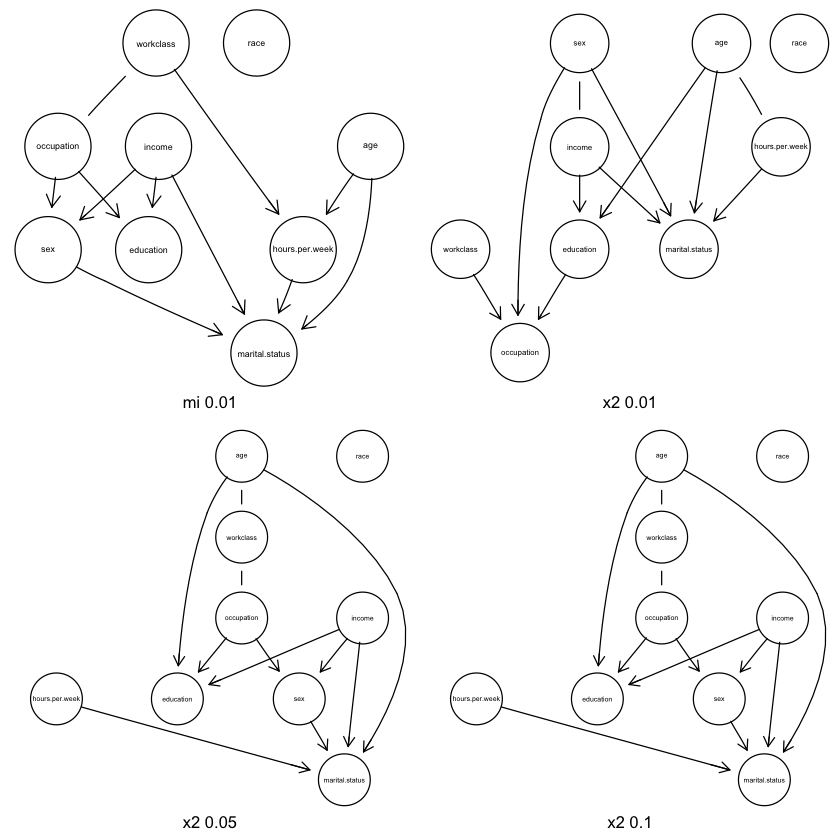

In [168]:
par(mfrow=c(2,2))
graphviz.plot(dags[[1]],sub=paste(combinations[1,1], combinations[1,2], sep = " "))
graphviz.plot(dags[[3]],sub=paste(combinations[3,1], combinations[3,2], sep = " "))
graphviz.plot(dags[[6]],sub=paste(combinations[6,1], combinations[6,2], sep = " "))
graphviz.plot(dags[[9]],sub=paste(combinations[9,1], combinations[9,2], sep = " "))


In [169]:
print(paste(values[1]))
print(paste(values[3]))
print(paste(values[6]))
print(paste(values[9]))

[1] "19"
[1] "21"
[1] "25"
[1] "25"


## Tabu Search
### Define parameters values

In [170]:
# test different scores: log-likelihood, Akaike information criterion, Bayesian information criterion
scores <- c('loglik', 'aic', 'bic')
# test different length of tabu lists
tabu_l <- c(1, 5, 10)
combinations = expand.grid(scores, tabu_l)

### Learn networks with different parameters and calculate metric

In [171]:
dags <- list()
values <- list()
for(i in 1:nrow(combinations)){
    params <- combinations[i,]
    pdag <- tabu(d, score=as.character(params[[1]]), tabu=params[[2]])
    dags <- append(dags, list(pdag))
    values[i] <- list(metric(pdag, bn_our_network))
    print(paste(values[i]))
}


[1] "37"
[1] "24"
[1] "20"
[1] "37"
[1] "26"
[1] "22"
[1] "37"
[1] "27"
[1] "22"


In [172]:
print('Distinct graphs')
compare_equal(combinations, dags)

[1] "Distinct graphs"
[1] 1 2
[1] 1 3
[1] 1 4
[1] 1 5
[1] 1 6
[1] 1 7
[1] 1 8
[1] 1 9
[1] 2 3
[1] 2 4
[1] 2 5
[1] 2 6
[1] 2 7
[1] 2 8
[1] 2 9
[1] 3 4
[1] 3 5
[1] 3 6
[1] 3 7
[1] 3 8
[1] 3 9
[1] 4 5
[1] 4 6
[1] 4 7
[1] 4 8
[1] 4 9
[1] 5 6
[1] 5 7
[1] 5 8
[1] 5 9
[1] 6 7
[1] 6 8
[1] 7 8


It can be seen that all graphs are distinct from each other except for graph 6 and 9.

### Plot learned networks

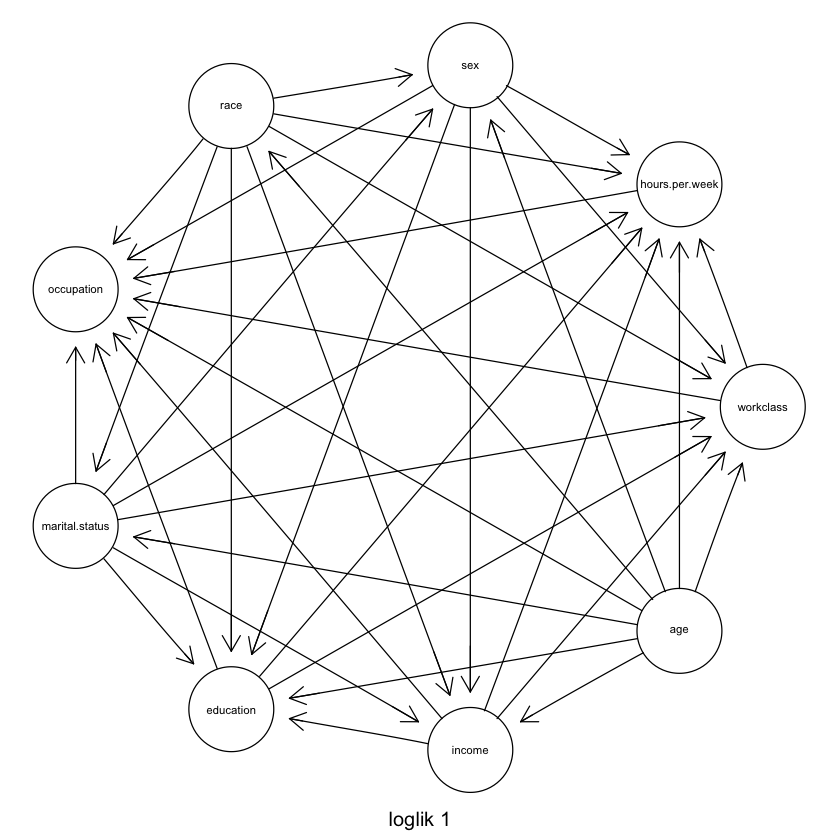

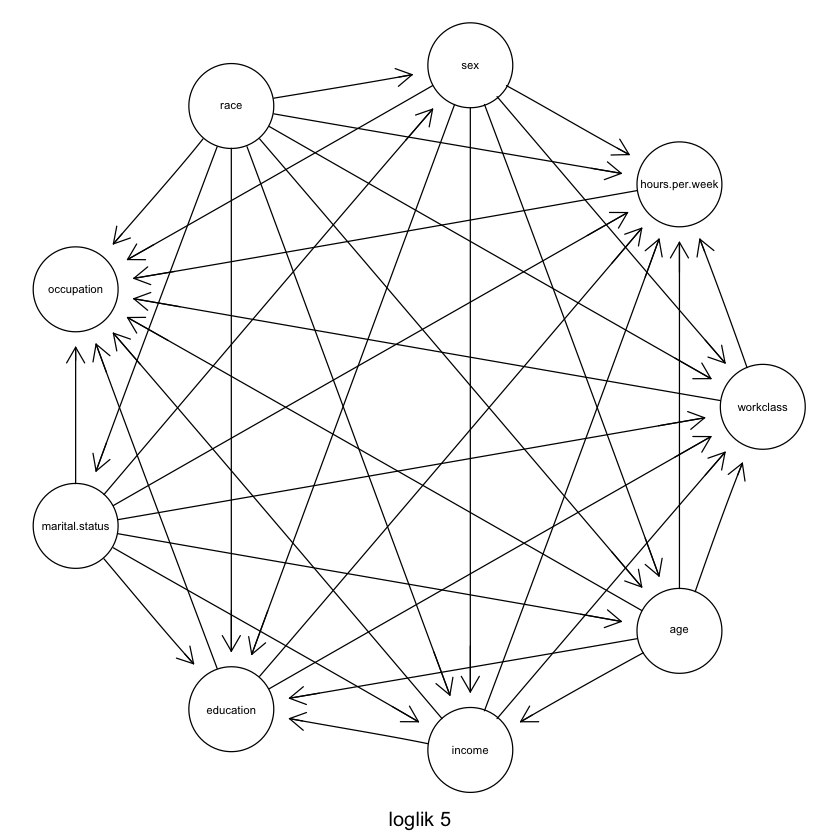

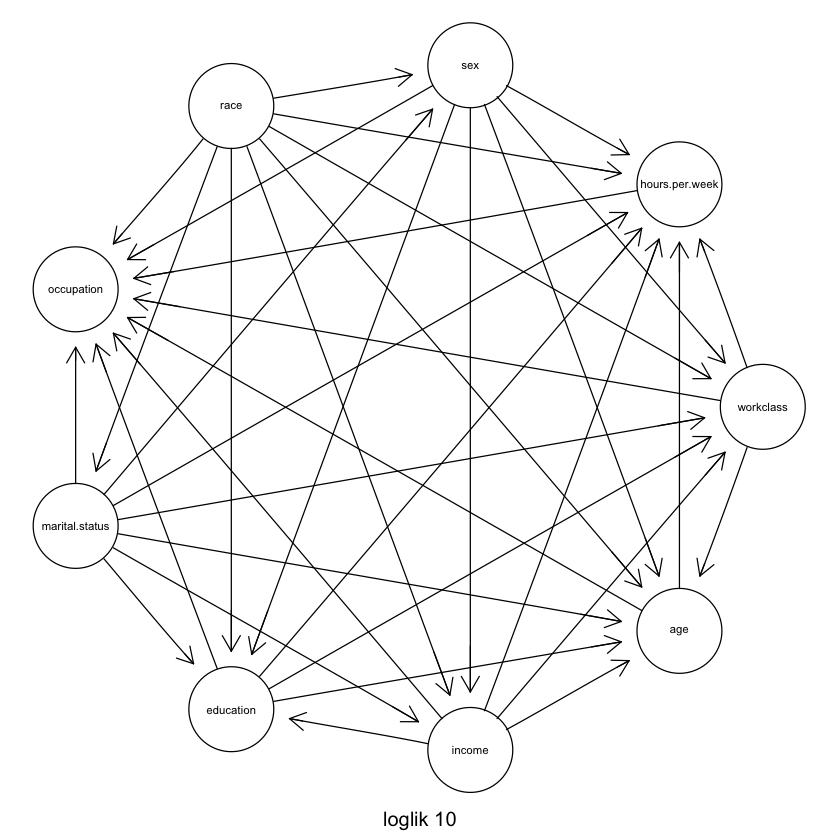

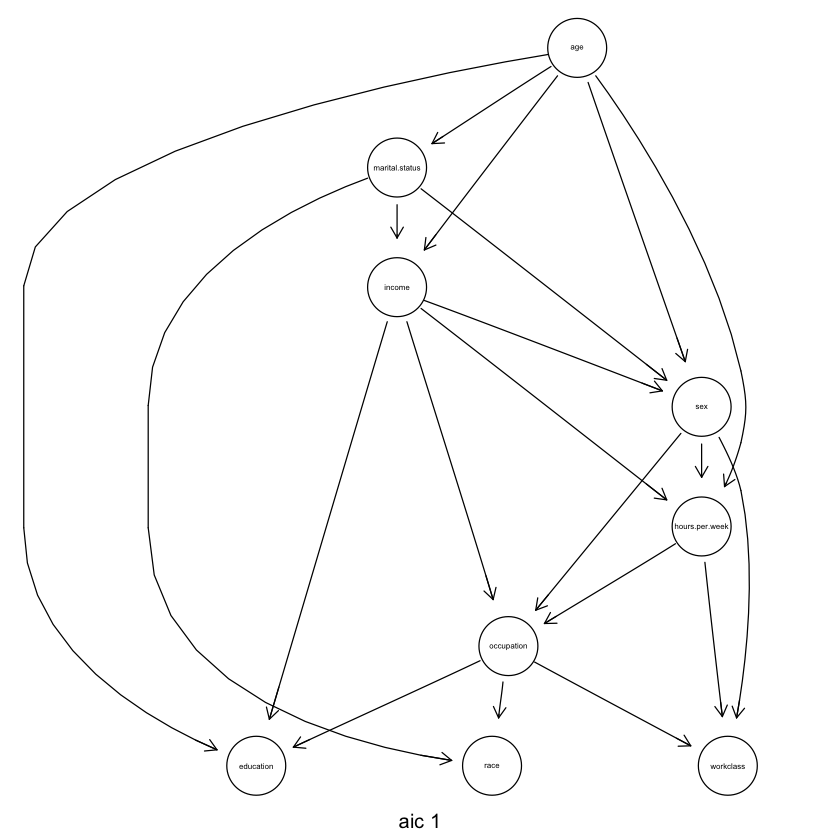

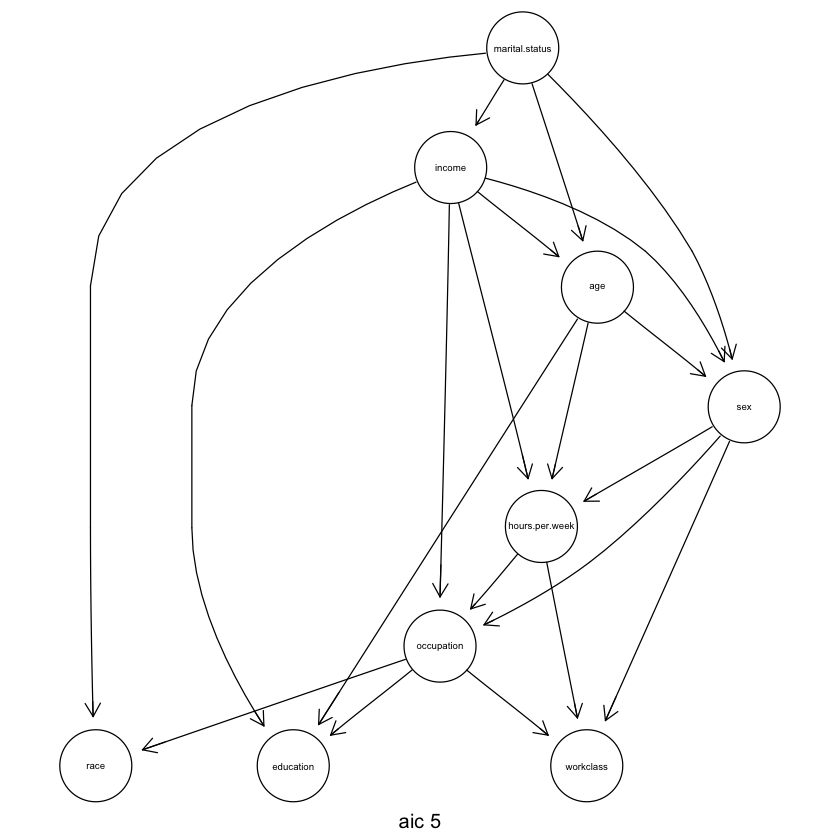

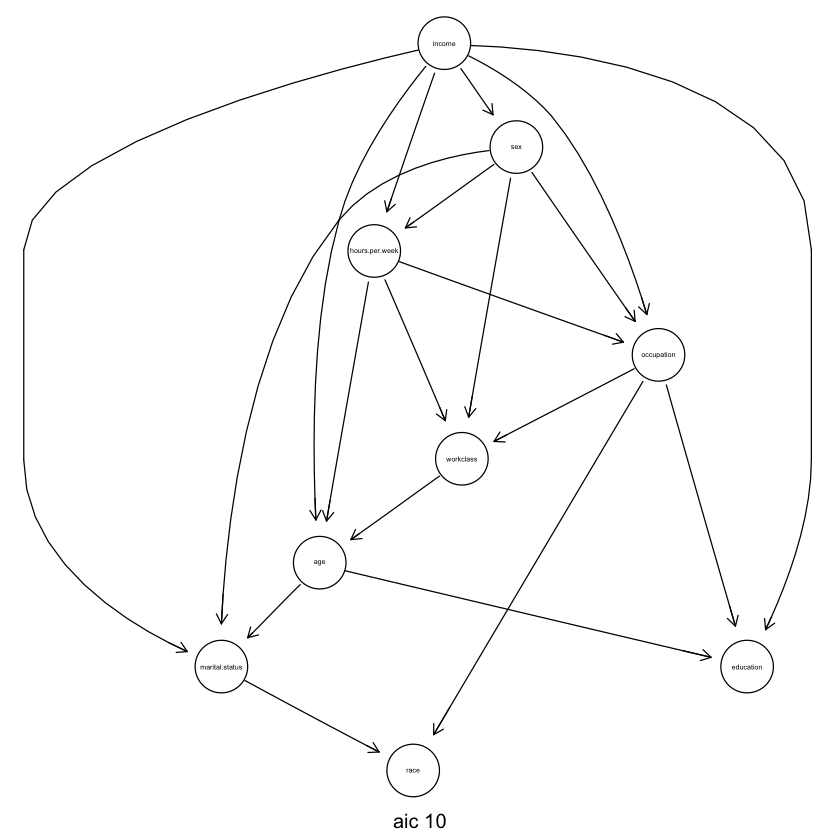

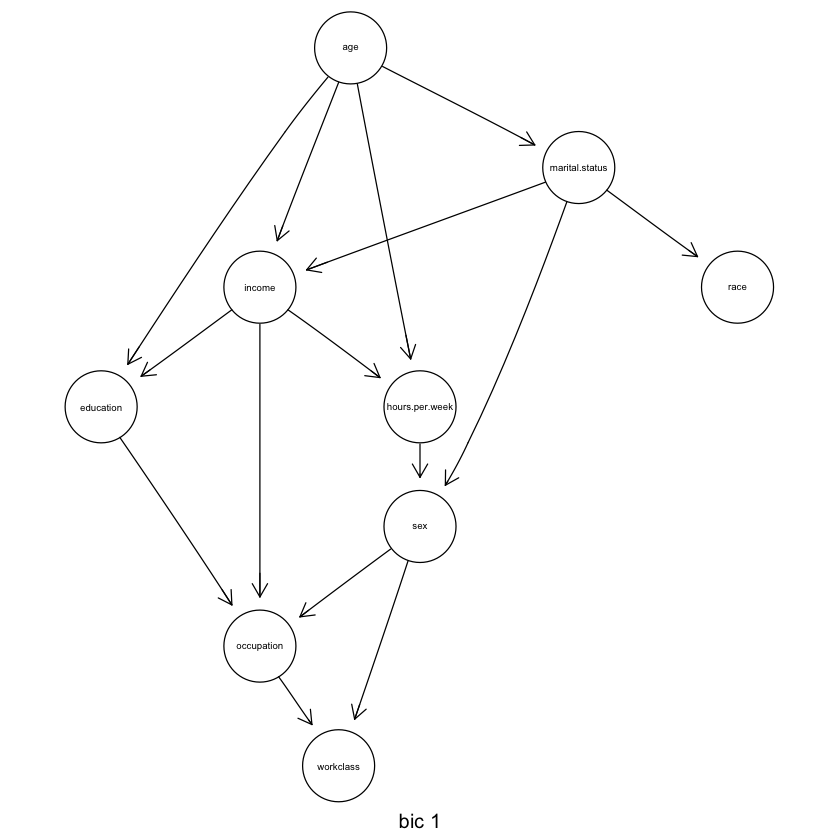

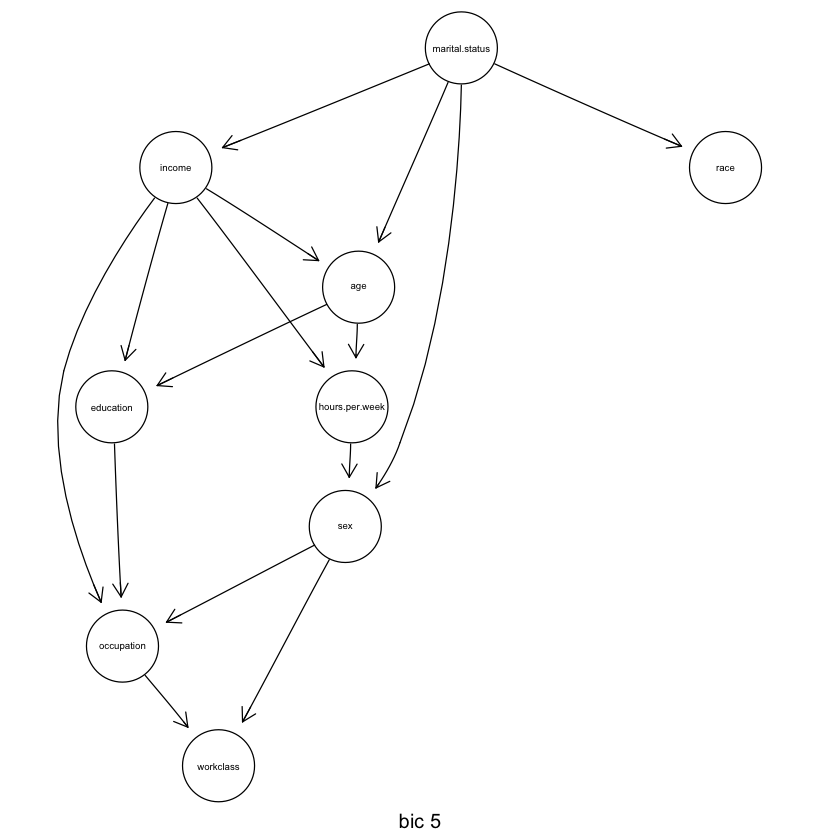

In [187]:
graphviz.plot(dags[[1]],sub=paste(combinations[1,1], combinations[1,2], sep = " "), layout='circo')
graphviz.plot(dags[[4]],sub=paste(combinations[4,1], combinations[4,2], sep = " "), layout='circo')
graphviz.plot(dags[[7]],sub=paste(combinations[7,1], combinations[7,2], sep = " "), layout='circo')

graphviz.plot(dags[[2]],sub=paste(combinations[2,1], combinations[2,2], sep = " "))
graphviz.plot(dags[[5]],sub=paste(combinations[5,1], combinations[5,2], sep = " "))
graphviz.plot(dags[[8]],sub=paste(combinations[8,1], combinations[8,2], sep = " "))

graphviz.plot(dags[[3]],sub=paste(combinations[3,1], combinations[3,2], sep = " "))
graphviz.plot(dags[[6]],sub=paste(combinations[6,1], combinations[6,2], sep = " "))



In [188]:
print(paste(values[1]))
print(paste(values[4]))
print(paste(values[7]))

print(paste(values[2]))
print(paste(values[5]))
print(paste(values[8]))

print(paste(values[3]))
print(paste(values[6]))



[1] "37"
[1] "37"
[1] "37"
[1] "24"
[1] "26"
[1] "27"
[1] "20"
[1] "22"
